In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
flow_file= "./data/PEMS04/PEMS04.npz"
csv_file = "./data/PEMS04/distance.csv"
import pandas as pd
data = np.load(flow_file)
df = pd.read_csv(csv_file)
TS = data['data']
flow = TS[:,:,0]
# k is the sensor id
k = 56
# time serie of sensor k
PeMS = pd.DataFrame(flow[:,k])
#creation of the datetime index
start_date = "2018-01-01 00:00:00"
end_date = "2018-02-28 23:55:00"
interval = "5min"
index = pd.date_range(start=start_date, end=end_date, freq=interval)
PeMS = PeMS.set_index(index)

In [13]:
train_data= PeMS[:'2018-02-10 00:00:00']
val_data =  PeMS['2018-02-10 00:00:00':'2018-02-14 00:00:00']
test_data = PeMS['2018-02-14 00:00:00':]

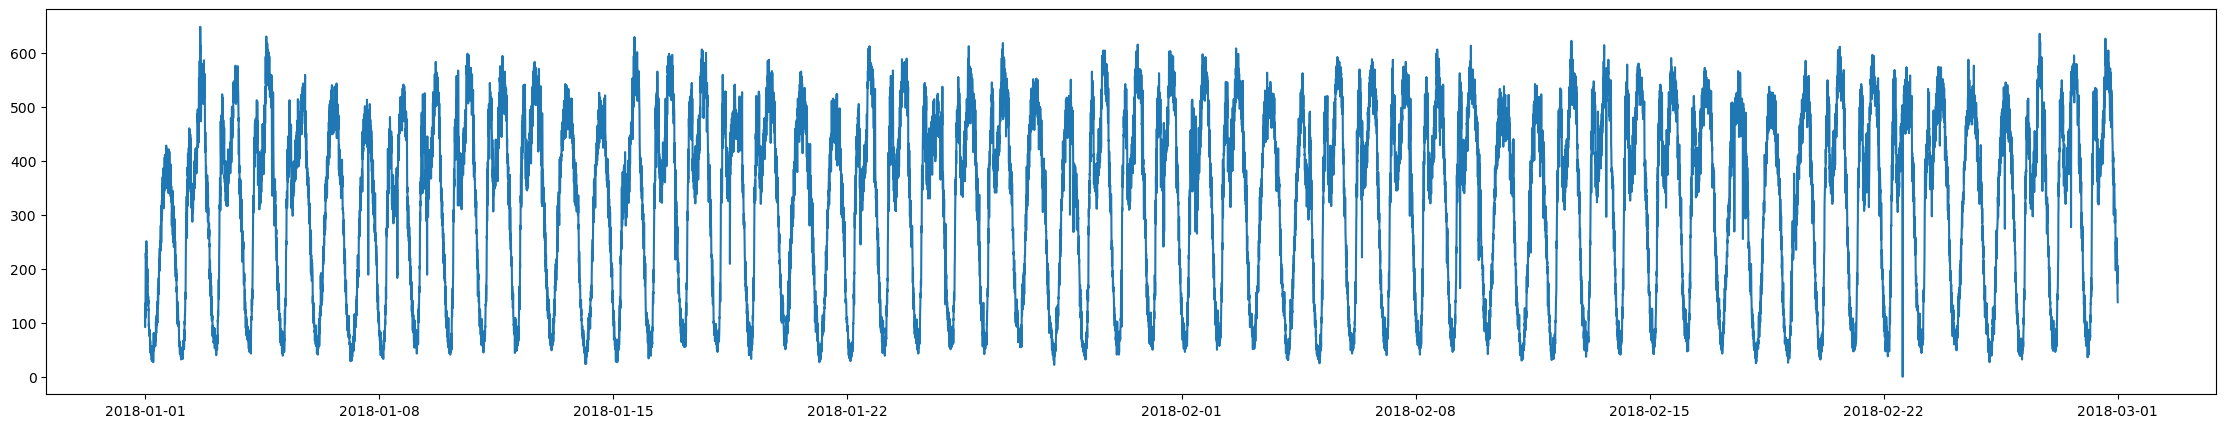

In [14]:
plt.figure(figsize=(28, 5))
plt.plot(PeMS)

In [15]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [16]:
# Define a PyTorch dataset to generate input/target pairs for the LSTM model
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride):
        self.data = data
        self.window_size = window_size
        self.stride = stride

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        inputs = self.data[idx:idx+self.window_size]
        target = self.data[idx+self.window_size]
        return inputs, target

In [17]:
# Define your LSTM model here with 6 LSTM layers and 1 fully connected layer
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the sliding window size and stride
window_size = 7
stride = 1
layers = 6
# Create datasets and data loaders for training, validation, and test sets
train_dataset = TimeSeriesDataset(train_data.values, window_size, stride)
val_dataset = TimeSeriesDataset(val_data.values, window_size, stride)
test_dataset = TimeSeriesDataset(test_data.values, window_size, stride)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
train_loader = [(inputs.to(device), targets.to(device)) for inputs, targets in train_loader]

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
val_loader = [(inputs.to(device), targets.to(device)) for inputs, targets in val_loader]

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_loader = [(inputs.to(device), targets.to(device)) for inputs, targets in test_loader]

In [19]:

# Train your model and evaluate on the validation set
num_epochs = 200
# Instantiate your LSTM model and define the loss function and optimizer
model = LSTMModel(input_size=1, hidden_size=32, num_layers=layers, output_size=1)
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
best_val_loss = float('inf')
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    train_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_losses.append(loss.item())
    val_loss = 0.0
    
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs.float())
        loss = criterion(outputs, targets.float())
        val_loss += loss.item()
        
    val_loss /= len(val_loader)
    valid_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'central'+str(k)+'.pth')
    
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/200, Training Loss: 46667073.0808, Validation Loss: 125173.4078
Epoch 2/200, Training Loss: 44003361.1716, Validation Loss: 118578.4379
Epoch 3/200, Training Loss: 41703120.5480, Validation Loss: 112465.7529
Epoch 4/200, Training Loss: 39550604.7752, Validation Loss: 106714.5484
Epoch 5/200, Training Loss: 37519502.9720, Validation Loss: 101279.4724
Epoch 6/200, Training Loss: 35597486.0909, Validation Loss: 96134.3451
Epoch 7/200, Training Loss: 33776704.2336, Validation Loss: 91260.9263
Epoch 8/200, Training Loss: 32051422.9816, Validation Loss: 86645.2975
Epoch 9/200, Training Loss: 30417138.2083, Validation Loss: 82276.2214
Epoch 10/200, Training Loss: 28870144.8283, Validation Loss: 78144.2550
Epoch 11/200, Training Loss: 27407286.0113, Validation Loss: 74241.2444
Epoch 12/200, Training Loss: 26025791.0277, Validation Loss: 70559.8938
Epoch 13/200, Training Loss: 24653043.0973, Validation Loss: 66545.3516
Epoch 14/200, Training Loss: 23231710.6863, Validation Loss: 62738.9

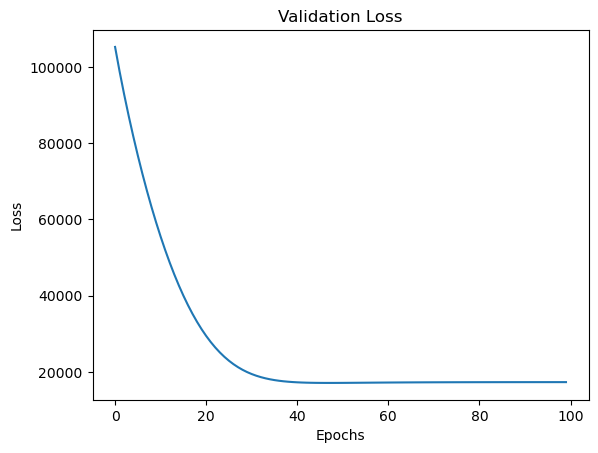

In [29]:
plt.plot(valid_losses,label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

In [30]:
# Load the best model and evaluate on the test set
n=1
best_model =  LSTMModel(input_size=1, hidden_size=32, num_layers=layers, output_size=n)
best_model.load_state_dict(torch.load('central'+str(k)+'.pth'))
best_model.double()
best_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate the model on the test set
test_loss = 0.0
predictions = []
actuals = []
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs = inputs.to(device)
        targets = targets.to(device)
        x = torch.Tensor(inputs).unsqueeze(1).to(device)
        y = torch.Tensor(targets).unsqueeze(0).to(device)
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        # Save the predictions and actual values for plotting later
        predictions.append(outputs.cpu().numpy())
        actuals.append(targets.cpu().numpy())
test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")
# Concatenate the predictions and actuals
predictions = np.concatenate(predictions, axis=0)
actuals = np.concatenate(actuals, axis=0)

RuntimeError: Input and parameter tensors are not at the same device, found input tensor at cuda:0 and parameter tensor at cpu

In [33]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from random import randint
EPSILON = 1e-10
i=k
plt.figure(figsize=(28, 5))
plt.title('Actual vs Prediction of sensor N° {}'.format(PeMS.columns[i]))
y_pred = predictions[:,i]
y_true = actuals[:,i]
plt.plot(test_data.index[window_size:],y_true, label='Actuals')
plt.plot(test_data.index[window_size:],y_pred, label='Predictions')
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
maape =  np.mean(np.arctan(np.abs((y_true - y_pred) / (y_true + EPSILON))))
# Add evaluation metrics to the plot
plt.annotate(f'MAE: {mae:.2f}', xy=(0.005, 0.6), xycoords='axes fraction')
plt.annotate(f'RMSE: {rmse:.2f}', xy=(0.005, 0.55), xycoords='axes fraction')
plt.annotate(f'MAAPE: {maape:.2f}', xy=(0.005, 0.5), xycoords='axes fraction')
# Set x and y labels
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
print(mae,rmse,maape)
plt.show()


IndexError: index 5 is out of bounds for axis 0 with size 1

<Figure size 2800x500 with 0 Axes>